In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
%matplotlib inline

# Model 

There are two states (A,B), hence the process is given by the vector (m,1-m)

The transitions are : 
- B becomes A with probability $1$
- Each A becomes B with probability $\alpha*m$

The fixed point is $m=(\sqrt{1+4\alpha}-1)/(2\alpha)$
- It is a stable fixed point iif $\alpha < 0.75$


1.1102230246251565e-16 0.6666666666666666


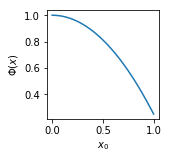

In [3]:
alpha=0.5
alpha=0.75

def phi(m):
    return( 1 - alpha*m**2)

pi = (np.sqrt(1+4*alpha)-1)/(2*alpha)
print(phi( pi ) - pi,pi)

m0 = 0.7

x = np.linspace(0,1,1000)
y = [phi(x) for x in x]
f = plt.figure()
f.set_size_inches(2,2)
plt.plot(x,y)
plt.xlabel('$x_0$')
plt.ylabel('$\Phi(x)$')
f.savefig('phi_unstable.pdf',bbox_inches='tight')

# Mean field approximation

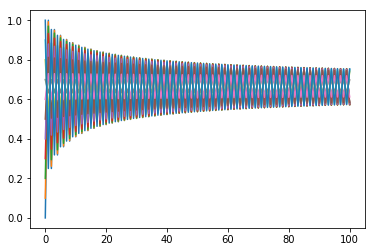

In [4]:
def mean_field(m0,T):
    m = m0
    M=[m0]
    for t in range(T):
        m = phi(m)
        M.append(m)
    return(np.array(M))
for m0 in np.linspace(0,1,11):
    plt.plot(mean_field(m0,100))

# Refined mean field

In [5]:
def A(m):
    return(-2*alpha*m)
def B(m):
    return(-2*alpha)
def Gamma(m):
    return(m*(1-alpha*m)*alpha*m)
def refined_mean_field(m0,T):
    V = [0]
    W = [0]
    M = [m0]
    v = 0
    w = 0
    m = m0
    for t in range(T):
        v = A(m)*v + 1/2 * B(m) * w
        w = Gamma(m) + A(m)*w*A(m)
        m = phi(m)
        M.append(m)
        V.append(v)
        W.append(w)
    return(np.array(M),np.array(V),np.array(W))
m0 = 0.7
(M,V,W) = refined_mean_field(m0,100)

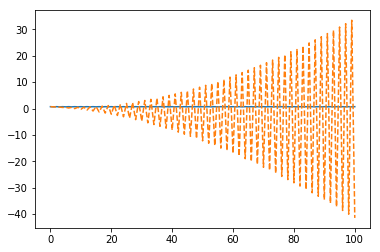

In [6]:
plt.plot(M)
plt.plot(M+V,'--')


# Exact model

The system is composed of N+1 states

In [7]:
def exactMatrix(N):
    M = np.zeros(shape=(N+1,N+1))
    M[0,N] = 1
    for i in range(N+1):
        for j in range(0,i+1):
            M[i,N-j] = binom.pmf(j,i, alpha*(i/N) )
    return(M)
def averageValue(x):
    N = len(x)-1
    return(np.sum(x*np.arange(0,N+1))/N)
def exactAverage(m0,N,T):
    m = np.zeros(N+1)
    m[int(m0*N)] = 1
    M=[averageValue(m)]
    kernel = exactMatrix(N)
    for t in range(T):
        m = np.tensordot(m,kernel,1)
        M.append(averageValue(m))
    return(M)
exactMatrix(2)

array([[0.    , 0.    , 1.    ],
       [0.    , 0.375 , 0.625 ],
       [0.5625, 0.375 , 0.0625]])

0.689219495194604 0.6838646966577308
0.6976809174404174 0.6967932133238715
0.6376610130226661 0.391286736722584
0.6524222695556603 0.5745986471116804
0.6096635470478919 0.616210764862366
0.6680702405057156 0.597598365188642


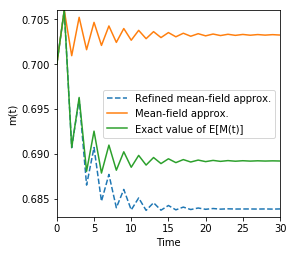

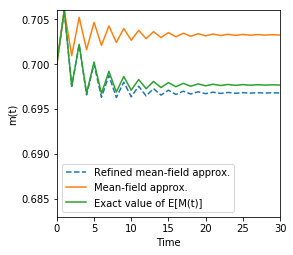

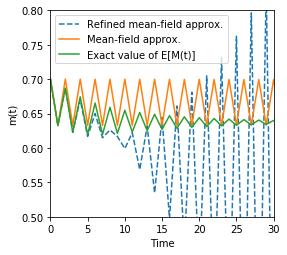

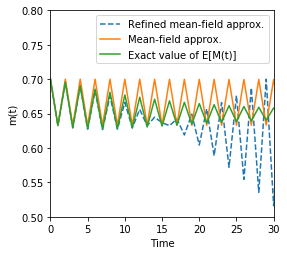

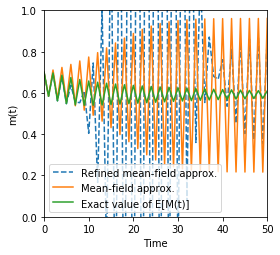

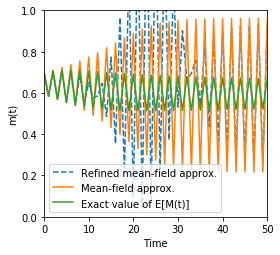

In [8]:
for alpha in [0.6,0.75,0.85]:
    for N in [10,30]:
        f = plt.figure()
        f.set_size_inches(4,3.8)
        m0 = 0.7
        M,V,W = refined_mean_field(m0,50)
        Msimu = exactAverage(m0,N,50)
        plt.plot(M+V/(N),'--')
        plt.plot(M,'-')
        plt.plot(Msimu)
        plt.xlabel('Time')
        plt.ylabel('m(t)')
        plt.legend(('Refined mean-field approx.','Mean-field approx.','Exact value of E[M(t)]'))
        if alpha==0.6:
            plt.xlim([0,30])
            plt.ylim([0.683,0.706])
        elif alpha==0.75:
            plt.xlim([0,30])
            plt.ylim([0.5,0.8])
        else:
            plt.ylim([0,1])
            plt.xlim([0,50])
        
        f.savefig('unstable1D_a{}_N{}.pdf'.format(int(alpha*100),N),bbox_inches='tight')
        print(Msimu[-1],(M[-1]+M[-2])/2+(V[-1]+V[-2])/2/N)

In [9]:
alpha=0.75
M,V,W = refined_mean_field(m0,50)
xSimu = []
myN = np.array([1,2,3,5,10,20,30,50,70,100,120])
for N in myN:
    Msimu = exactAverage(0.3,N,100)
    xSimu.append( (Msimu[-1]+Msimu[-2])/2 )
xSimu = np.array(xSimu)

0.6662546023062286 0.6666666666666666


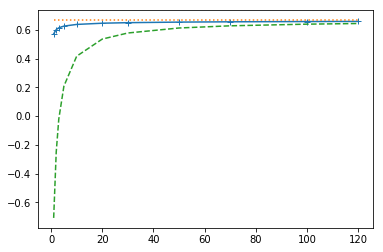

In [35]:
mf = (M[-1]+M[-2])/2
print(mf,pi)
V_th = (V[-1]+V[-2])/2
plt.plot(myN,xSimu,'+-')
plt.plot(myN,np.ones(len(myN))*mf,':')
plt.plot(myN,np.ones(len(myN))*mf+V_th/(1+myN),'--')

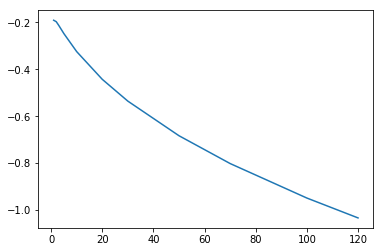

In [36]:
plt.plot(myN,(1+myN)*(xSimu-pi))
#plt.plot(myN,np.ones(len(myN))*V[-1],'--')


# Steady-state 

In the case "$\alpha=0.75$, the convergence to the steady-state seem to be in $O(1/\sqrt{N})$ and not $1/N$. This seems to indicate that this assumption is needed. 

In [8]:
alpha=0.75

def steady(N):
    A = np.transpose(exactMatrix(N))
    l,x=np.linalg.eig(A)
    ss = x[:,l>.99].reshape((N+1))
    ss = ss/sum(ss)
    #print(ss)
    return(np.real(averageValue(ss)))

In [9]:
myN = np.arange(10,200,10)
errorMF = np.array([(steady(N)-pi) for N in myN])

for (i,N) in enumerate(myN):
    print(N,N*(errorMF[i]-pi))


10 -6.961482561767679
20 -13.755091771901863
30 -20.519520308741154
40 -27.268692734281714
50 -34.00808596232559
60 -40.74052251094618
70 -47.46768303446866
80 -54.19066410339694
90 -60.91022810680931
100 -67.62693050506758
110 -74.34119083594474
120 -81.05333516606582
130 -87.76362288058843
140 -94.4722643422919
150 -101.17943295770672
160 -107.88527367393516
170 -114.58990911756543
180 -121.29344412924725
190 -127.99596917841781


-0.09746054252850808 0.01409835786697525


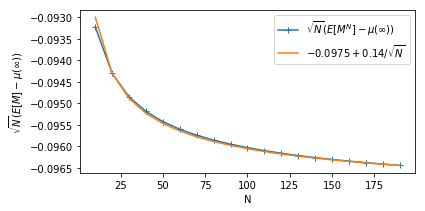

In [30]:
f = plt.figure()
f.set_size_inches(6,3)
V = np.array(errorMF)*np.sqrt(myN)
plt.plot(myN,V,'+-')
b = (V[-1]-V[1])/(1/np.sqrt(190)-1/np.sqrt(20))
a = V[-1]-b/np.sqrt(190)
print(a,b)
#a=-0.09746; b=0.0141
plt.plot(myN, a+b/np.sqrt(myN))
plt.legend(('$\sqrt{N}(E[M^N]-\mu(\infty))$','$-0.0975+0.14 / \sqrt{N}$'))
plt.xlabel('N')
plt.ylabel(r'$\sqrt{N}(E[M]-\mu(\infty))$')
f.savefig('unstable1D_steadyState.pdf',bbox_inches='tight')

# Rate of convergence to the fixed point

Note : as $\pi$ is not exponentially stable, the dynamical system converges *very* slowly to its fixed point. 

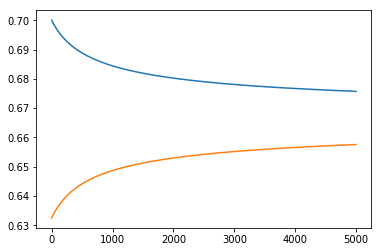

In [11]:
T=10000
X = mean_field(m0,T)
Xp = [X[i] for i in range(T) if i%2==0]
Xm = [X[i] for i in range(T) if i%2==1]
plt.plot(Xp)
plt.plot(Xm)


## Role of the initial value

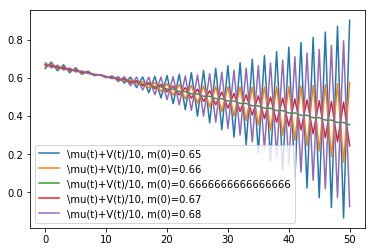

In [24]:
N=10
myM0 = [0.65,0.66, 2/3.,0.67,0.68]
for m0 in myM0: 
    M,V,W = refined_mean_field(m0,50)
    plt.plot(M+V/N)
plt.legend(['\mu(t)+V(t)/10, m(0)={}'.format(m0) for m0 in myM0])
plt.savefig('unstable1D_roleOfM0.pdf')

## Figures for the slides

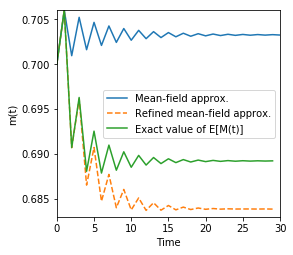

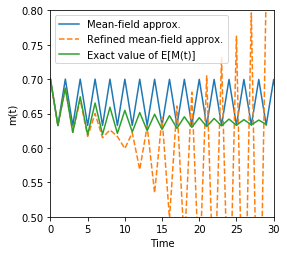

In [25]:
for alpha in [0.6,0.75]:
    for N in [10]:
        f = plt.figure()
        f.set_size_inches(4,3.8)
        m0 = 0.7
        M,V,W = refined_mean_field(m0,50)
        Msimu = exactAverage(m0,N,50)
        plt.plot(M,'-')
        plt.xlabel('Time')
        plt.ylabel('m(t)')
        plt.ylim(([0.683,0.706] if alpha==0.6 else [0.5,0.8]) )
        plt.xlim([0,30])
        plt.legend(('Mean-field approx.','Refined mean-field approx.','Exact value of E[M(t)]'))
        f.savefig('unstable1D_onlyMFa{}_N{}.pdf'.format(int(alpha*100),N),bbox_inches='tight')
        
        for time_limit in [8,30]:
            plt.clf()
            plt.plot(M,'-')
            plt.xlabel('Time')
            plt.ylabel('m(t)')
            plt.plot( (M+V/N)[0:time_limit],'--')
            plt.plot(Msimu[0:time_limit])
            plt.legend(('Mean-field approx.','Refined mean-field approx.','Exact value of E[M(t)]'))
            plt.ylim(([0.683,0.706] if alpha==0.6 else [0.5,0.8]) )
            plt.xlim([0,30])
            if time_limit < 10:
                f.savefig('unstable1D_TL_a{}_N{}.pdf'.format(int(alpha*100),N),bbox_inches='tight')
            else:
                f.savefig('unstable1D_a{}_N{}.pdf'.format(int(alpha*100),N),bbox_inches='tight')